<font size=6 color=blue>
    <b>
        Analysis of Oxford Weather Data
    </b>
</font>

<font size = 2>
    <b>
        Finn McCool July 2019
    </b>
</font>

<font size=5><strong>Using Python - Pandas - Matplot and Scipy</strong></font>

<font size=4 color=blue>
    <b>
    <a
       href="https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data">The Met Office Data
        </a>
    </b>
    </font>

<font size = 4>
    <strong>Oxford</strong>
<div>
    <font size=3>
        Location: 450900E 207200N, Lat 51.761 Lon -1.262, 63 metres amsl**
Estimated data is marked with a * after the value.
Missing data (more than 2 days missing in month) is marked by  ---.
Sunshine data taken from an automatic Kipp & Zonen sensor marked with a #, otherwise sunshine ## data taken from a Campbell Stokes recorder.
    </font>
    </div>

<strong>The co-ordinates are in Woodstock Road,near St. Anne's College. Roughly at garden level.</strong>

<img src='img/oxfordMap.png'/>

<font size=4 color=blue>
    <b>
        <a href="https://www.latlong.net/lat-long-dms.html"Map> Data courtesy of lat-long-dms</a>
    </b>
</font>

<font size=5 font-family='Arial'>
    <b>
        Introduction
    </b>
</font>

<font size=4>
    <p>I have never been convinced with the masked-man fallacy of the term 'climate change'. A mere 20,000 years ago, I would have been sitting on top of almost a kilometre of ice in relation to where my desk is today. It is therefore an obvious fact that the climate has changed.</P>
    <p>It is also a proven fact that there was an extremely cold period lasting more than 500 years from the 1300's until 1850 or so, called the 'Little ice Age'. The 'climate' had radically departed from the 'Medieval Warm' period.</p>
    <p>When today's prophets of doom talk about 'climate change' what they are really referring to is Anthropogenic Global Warming (AGW) caused by a trace gas (CO2).  A trace gas which is essential for life on this planet.</p>
    <p>A Mean Global temperature is probably one of the most meaningless numbers bandied about by 'climate' activists such as Extinction Rebellion. I thought it would be worthwhile to look at the Met Office's oldest data set from Oxford to see what has actually happened over the last 166 years or so.</p>
    <p>Unfortunately, it's a small data set of average Maximum and Minimum monthly temperatures but it is localised on one spot on the surface of the planet from the end of the 'Little Ice Age'.</p>
    <p>.It's also a great little data set to learn some Python, simple statistics and how to draw some visual conclusions via Matplot. So, let's jump right in,</p>
</font>

<font size=5 font-family='Arial'>
    <b>
        Analysis of Temperature Data for Oxford, UK. 1853 - 2018
    </b>
</font>

<font size =4>
    <b>
        Import all the necessary modules
    </b>
</font>

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import seaborn as sns

<font size =4>
    <b>
        Create the Pandas data frame from the CSV file
    </b>
</font>

<font size=3 color=blue>
    TminC has to be changed to a float using <b>coerce</b>.  I forgot that this column contained some entries marked with an <b>*</b> which was more than likely the problem and led to problems with creating graphs. It is worthwhile to make a copy of the original file and remove these with a simple Linux <b>sed</b> command.
</font>

In [37]:
oweather = pd.read_csv('oxfordweather2.csv')

In [38]:
#oweather.dtypes  #Check the data types of the df if if you want

In [39]:
oweather['TminC'] = pd.to_numeric(oweather['TminC'],errors='coerce')

<font size =4>
    <b>
        Variables
    </b>
</font>

<font size=3 color=blue>
    The variable, <b>mnth</b> is used to query for a particular month and <b>tmp</b> represents TmaxC or TminC as an integer, 2 or 3. The variable <b>dk</b> is used to hold the year and temperature values. I will iterate over the data frame using the <b>.iterrows</b> method and select the temperature for the month based on the values in mnth and tmp and store them in a list
One more variable is needed to store a string defining what temperature we are using which will be <b>tmptxt</b> used mainly for graph titles.
</font>

<font size=3 color=green>
    <b>Change these variables to give a different month or temperature to analyse.</b>

In [40]:
mnth = 3
tmp = 3
dk =[]

for index, row in oweather.iterrows():
    if row[1] == mnth:
        dk.append([row[0],row[tmp]])

if tmp == 2:
    tmptxt = 'Max Temperature'
else:
    tmptxt = 'Min Temperature'

<font size =4>
    <b>
        Create the new data frame, dfTmp and add some headers.
    </b>
</font>

In [41]:
dfTmp = pd.DataFrame(dk)
dfTmp.columns = ['Year','Temperature']

<font size =4>
    <b>
        Get some basic Stats in a variety of ways.
    </b>
</font>

In [42]:
print('The following values are for the %s recorded in month %i'%(tmptxt,mnth))

The following values are for the Min Temperature recorded in month 3


In [43]:
print(dfTmp['Temperature'].describe())

count    166.000000
mean       2.469277
std        1.510716
min       -1.200000
25%        1.425000
50%        2.200000
75%        3.600000
max        6.400000
Name: Temperature, dtype: float64


In [44]:
print(dfTmp.loc[dfTmp['Temperature'].idxmax()],'\n')     #Maximum Temperature

print(dfTmp.loc[dfTmp['Temperature'].idxmin()])          #Minimum Temperature

Year           1981.0
Temperature       6.4
Name: 128, dtype: float64 

Year           1883.0
Temperature      -1.2
Name: 30, dtype: float64


In [45]:
sigma = dfTmp['Temperature'].std()
print('The Standard Deviation was %3.3f Degrees C'%sigma)

The Standard Deviation was 1.511 Degrees C


In [46]:
mu = dfTmp['Temperature'].mean()
print('The average temperature was %3.2f Degrees C'%mu)

The average temperature was 2.47 Degrees C


<font size =4>
    <b>
        Graphs
    </b>
</font>

<font size=3 color=blue>
    First we will create a normal distribution around the observed sample's Average and Standard Deviation using 10k points.
The measurements are from 1853 to 2018 giving 165 data points for each month. 10 bins should be sufficient. (_Sturge's Rule_)
The formula for Probability Density in Python can be found [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html)
The following code shows a visual representation of a PDF overlaid onto the actual data.
</font>

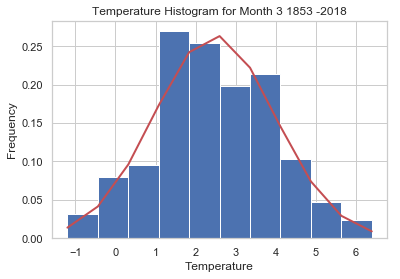

In [47]:
sNormal = np.random.normal(mu, sigma, 100000)
count, bins, ignored = plt.hist(dfTmp['Temperature'],10,density=True)
plt.title('Temperature Histogram for Month %i 1853 -2018'%(mnth))
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
          linewidth=2, color='r')
plt.show()

 <font size=3 color=blue>
    The next graph is a basic matplotlib scatter plot
</font>

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


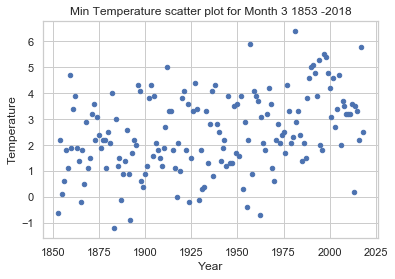

In [48]:
dfTmp.plot.scatter(x='Year',
                   y='Temperature',
                   title=('%s scatter plot for Month %i 1853 -2018'%(tmptxt,mnth)),
                   grid=True
                   )
plt.show()

<font size =4>
    <b>
        Let's try some Seaborn plots...
    </b>
</font>

<font size=3 color=blue>
    A basic scatter plot with a best fit line.
</font>

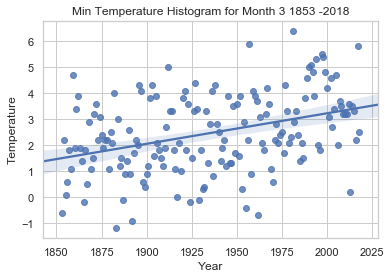

In [49]:
sns.set(context='notebook',style='whitegrid')

sns.regplot(x=dfTmp['Year'], 
            y=dfTmp['Temperature'], 
            fit_reg=True,
           )
plt.title('%s Histogram for Month %i 1853 -2018'%(tmptxt,mnth))
plt.show() 

<font size=3 color=blue>
    A plot of the temperatures showing higher temperatures as bigger points.
</font>

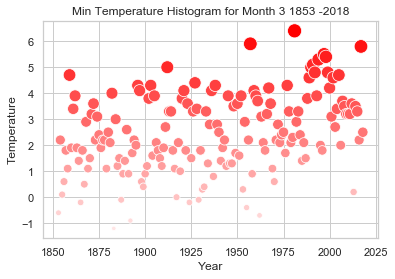

In [50]:
cmap = sns.light_palette("Red", as_cmap=True)

ax = sns.scatterplot(x="Year", y="Temperature",
                      size="Temperature",
                      sizes=(20, 200),
                      palette=cmap,
                      data=dfTmp,
                      hue='Temperature',
                      legend=False
                    )
plt.title('%s Histogram for Month %i 1853 -2018'%(tmptxt,mnth))
plt.show()

<font size=3 color=blue>
    My favourite. A heat map of the temperatures.
</font>

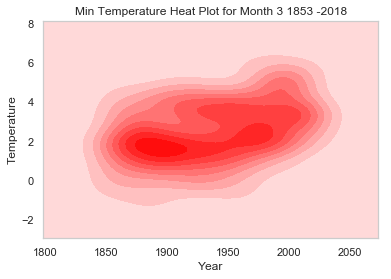

In [51]:
sns.kdeplot(dfTmp['Year'], dfTmp['Temperature'], cmap=cmap, shade=True)
plt.title('%s Heat Plot for Month %i 1853 -2018'%(tmptxt,mnth))
plt.show()

<font size=5 font-family='Arial'>
    <b>
        Analysis of Average Data
    </b>
</font>

<font size=3 color=blue>
    Create an average temperature as the difference between TmaxC and TminC, but <b>First</b> create a copy of the original data.
</font>

In [52]:
oweatherModified = oweather

avg = [ row['TmaxC'] - row['TminC'] for index, row in oweather.iterrows() ]

oweatherModified['TavgC'] = avg

<font size=3 color=blue>
    We still have the variable _mnth_ from our original input and the only temperature we are now interested in is _TavgC_. Let's create a new DF called dfAvg to hold all the data for a particular month and show some basic stats.
</font>

In [53]:
dkavg = []

for index, row in oweather.iterrows():
    if row[1] == mnth:
        dkavg.append([row[0],row['TavgC']])
dfAvg = pd.DataFrame(dkavg)
dfAvg.columns = ['Year','Average Temperature']

print(dfAvg.loc[dfAvg['Average Temperature'].idxmax()],'\n') #Maximum temperature

print(dfAvg.loc[dfAvg['Average Temperature'].idxmin()]) #Minimum Temperature

Year                   1929.0
Average Temperature      13.0
Name: 76, dtype: float64 

Year                   1981.0
Average Temperature       4.7
Name: 128, dtype: float64


In [54]:
sigmaAvg = dfAvg['Average Temperature'].std()

In [55]:
muAvg = dfAvg['Average Temperature'].mean()

<font size =4>
    <b>
        Just go through the same code as before, only now with the average temperature.
    </b>
</font>

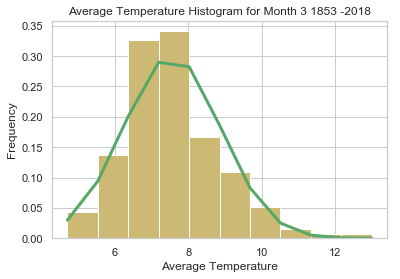

In [56]:
sNormal = np.random.normal(muAvg, sigmaAvg, 100000)
avgcount, avgbins, ignored = plt.hist(dfAvg['Average Temperature'],10,density=True,color='y')
plt.title('Average Temperature Histogram for Month %i 1853 -2018'%(mnth))
plt.xlabel('Average Temperature')
plt.ylabel('Frequency')
plt.plot(avgbins, 1/(sigmaAvg * np.sqrt(2 * np.pi)) *
                np.exp( - (avgbins - muAvg)**2 / (2 * sigmaAvg**2) ),
          linewidth=3, color='g')
plt.show()

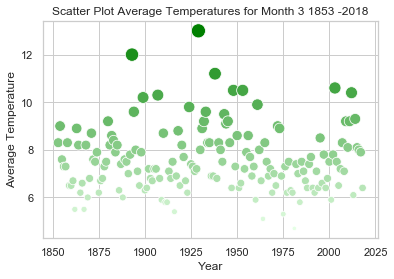

In [57]:
cmapAvg = sns.light_palette("Green", as_cmap=True)
ax = sns.scatterplot(x="Year", y="Average Temperature",
                      size="Average Temperature",
                      sizes=(20, 200),
                      palette=cmapAvg,
                      data=dfAvg,
                      hue='Average Temperature',
                      legend=False
                    )
plt.title('Scatter Plot Average Temperatures for Month %i 1853 -2018'%(mnth))
plt.show()

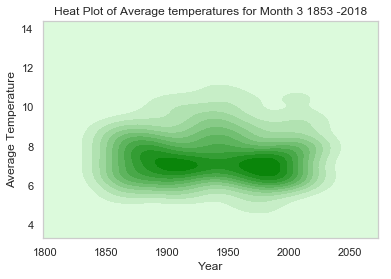

In [58]:
sns.kdeplot(dfAvg['Year'], 
            dfAvg['Average Temperature'], 
            cmap=cmapAvg, 
            shade=True
           )
plt.title('Heat Plot of Average temperatures for Month %i 1853 -2018'%(mnth))
plt.show()

<font size =5>
    <b>
        Conclusion
    </b>
</font>

<font size =3>
    <p>This has been an interesting study for me. If you code in any language, it should be to produce something which is useful, interesting and satisfying.</p>
    <p>It seems that it is dificult to predict how hot or cold any one month will be over the same month in any particular year.</p>
    <p>It's a nice data set to start using Python and thanks to the Met for making it available.</p>
    <p>In creating the Jupyter Notebook, I used HTML in preference to Mardown, principally because I wanted to learn how to use it in a simple environmnet.</p>
</font>

<font size=3>
    <p>The takeaway's from this little study, apart from refuting bogus claims of climate disaster, are:</p>
<ol>
    <li>Simple use of Pandas in Python for data analysis</li>
    <li>Some simple statistics</li>
    <li>Using Matplotlib and Seaborn for Drawing Graphs</li>
    <li>How to use Jupyter Lab</li>
    <li>Using HTML to format Jupyter notebooks</li>
    </ol>
</font>

<font size =3>
    <p>Hopefully, it will be of some use to you as you learn Python!</p>
    <p>It is not an attempt to analyse the causal mechanisms of how the planet's climate changes over millenia.</p>

<img src='img/finnmccool.png'>